## The spam filter

### Introduction

In this example, I develop a **spam filter**, that is, an algorithm that classifies e-mail messages as either spam or non-spam, based on a collection of attributes such as the frequency of certain words or characters. The algorithm is based on a **decision tree** obtained with the Python package **scikit-learn**. I use data collected at Hewlett-Packard by merging: (a) a collection of spam e-mail from the company postmaster and the individuals who had filed spam, and (b) a collection of non-spam e-mail, extracted from filed work and personal e-mail. 

In this example, I have to take into account that the false positive rate, that is, of non-spam messages wrongly classified as spam, is expected to be very low in a acceptable spam filter. The data set contains data on 4,601 e-mail messages. Among these messages, 1,813 have been classified as spam. The variables are:

* A dummy for the e-mail being considered spam (`spam`).

* 48 numeric variables whose names start with 'word_', followed by a word. They indicate the **frequency**, in percentage scale, with which that word appears in the message. Example: `word_make=0.21`, for a particular message, means that 0.21% of the words in the message match the word 'make'.

* 3 numeric variables indicating, respectively, the **average length** of uninterrupted sequences of capital letters, the length of the longest uninterrupted sequence of capital letters and the total number of capital letters in the message.

### Importing the data

I import the data with the `pandas` function `read_csv`. The data set has 4,601 rows and 52 columns, all numeric. I print the structure of the data set only for the first and the last five variables.

In [1]:
import pandas as pd
spam = pd.read_csv('https://raw.githubusercontent.com/iese-bad/' +
    'DataSci/master/Data/spam.csv')

In [2]:
spam.iloc[:, 0:5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 5 columns):
word_make       4601 non-null float64
word_address    4601 non-null float64
word_all        4601 non-null float64
word_3d         4601 non-null float64
word_our        4601 non-null float64
dtypes: float64(5)
memory usage: 179.8 KB


In [3]:
spam.iloc[:, 47:52].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 5 columns):
word_conference    4601 non-null float64
cap_ave            4601 non-null float64
cap_long           4601 non-null int64
cap_total          4601 non-null int64
spam               4601 non-null int64
dtypes: float64(2), int64(3)
memory usage: 179.8 KB


### Building a decision tree

I specify the `y` and `X` components of the equation as usual in scikit-learn unsupervised methods.

In [4]:
y = spam.iloc[:, 51]
X = spam.iloc[:, 0:51]

scikit-learn has a module called `tree`, with various decision tree methods. I use the method `DecisionTreeRegressor` for consistency with the R notebook of the same example and the method `export_graphviz` for plotting trees. Note that, for using this last method, you need to have **Graphviz** (which is an open source, independent app) installed in your computer.

In [5]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

Fitting a decision tree is the same as fitting any other supervised learning model in `scikit-learn`. The argument `min_impurity_decrease=0.01` will be justified below. Warning: this parameter was introduced in version 0.19 of scikit-learn, so you have to update it if your version is older.

In [6]:
TREE1 = DecisionTreeRegressor(min_impurity_decrease=0.01)
TREE1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.01,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Before evaluting this model, we plot the tree, for a better understanding of how it works. `export_graphviz` exports the tree to a format (`dot`) which can be managed by **Graphviz**. Graphviz is an open source app, not part of Python, which you need to have installed in your computer. The three last lines of the following code chunk are used for generating a PDF version of the DOT representation. 

In [7]:
dot_data = export_graphviz(TREE1, out_file=None,
  feature_names=spam.columns[0:51])
# import pydotplus
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('tree.pdf')

Assuming that Graphviz is installed, I load the package `graphviz` and ask for the plot. Note: the first two lines are needed in Windows for Python to find the Graphviz executable. Installing Graphviz with Homebrew in macintosh fixes this type of problem.

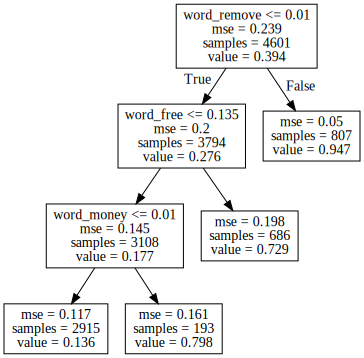

In [8]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import graphviz
graphviz.Source(dot_data)

This graph is easy to interpret. The box on top is the root node, with 4,601 instances. The average of the predicted variable (`spam`), that is, the spam rate, is 39.4%, and that the mean sum of squared residuals (actual value minus mean) is 0.239. The optimal split, based on `word_remove`, is the one that yields the maximum reduction of the sum of squared residuals or, equivalently, of the weighted average of the MSE values of the branches.

In the left branch (instances satisfying `word_remove<=0.01`), we get 3,749 instances, with 27.6% spam rate, and, in the right branch, 807 instances, with spam rate 94.7%. This last brach is not further split, because the potential splits would not improve the mse enough, given the `min_impurity_decrease=0.01` specification. On the left branch we see two more splits.

In the end, this tree partitionates the sample in four groups, corresponding to the four leaves. The spam rate in any of these leaves is taken as the score for all the instances in that leaf. So, we have four different scores: 0.947, 0.729, 0.136 and 0.798. We see below how to get this scores without plotting, which is not feasible for bigger trees.

### Predictive scores and confusion matrix

Since we are using `DecisionTreeRegressor` (with `DecisionTreeClassifier` is a bit more complicated), obtaining the scores is as easy as in a linear regression.

In [9]:
score1 = TREE1.predict(X)
conf1 = pd.crosstab(score1 > 0.5, spam['spam']==1)
print(conf1)

spam   False  True 
row_0              
False   2520    395
True     268   1418


In [10]:
tp1 = conf1.iloc[1, 1]/(conf1.iloc[0, 1] + conf1.iloc[1, 1])
tp1.round(3)

0.782

In [11]:
fp1 = conf1.iloc[1, 0]/(conf1.iloc[0, 0] + conf1.iloc[1, 0])
fp1.round(3)

0.096

Note that, in this case, the data set has been artificially created, by joining two collections which come from different sources. So, the proportion of spam in data is not the real one. This means that a statistic like the accuracy does not make sense. Nevertheless, we can evaluate the classifier examining the two columns of the confusion matrix separately, as we do when we look at the TP and FP rates. 

The TP rate is excellent, but the FP rate is a bit high for a spam filter. Can we improve these results with a better cutoff? Instead of exploring this with histograms, it is better to use crosstabulation here, since there are only 4 different scores, one for each leaf of the tree. 

In [12]:
print(pd.crosstab(score1, spam['spam']))

spam         0    1
row_0              
0.135506  2520  395
0.728863   186  500
0.797927    39  154
0.946716    43  764


We see in the table a wide gap between 0.136 and 0.729. This is a by-product of the tree algorithm, which selects the splits so that they produce extreme scores. Here, lowering the cutoff would increase the proportion of positives and, in particular, the FP rate would increase, an undesired effect. Raising the cutoff, the FP rate would decrease, which could be interesting, but we would stop filtering 500 spam messages, which would leave us with a very poor filter.

### Controlling pruning

In `DecisionTreeRegressor`, pruning is controlled by the complexity parameter `min_impurity_decrease`. Any split that does not decrease the overall lack of fit by a factor equal to the specified value is not attempted. The main role of this parameter is to save computing time by pruning off splits that are obviously not worthwhile.

To show you how this works, I change the specification to `cmin_impurity_decrease=0.001`, getting a tree with 21 leaves, involving 14 variables.

In [13]:
TREE2 = DecisionTreeRegressor(min_impurity_decrease=0.001)
TREE2.fit(X, y)
score2 = TREE2.predict(X)

In [14]:
conf2 = pd.crosstab(score2 > 0.5, spam['spam']==1)
print(conf2)

spam   False  True 
row_0              
False   2575    119
True     213   1694


In [15]:
tp2 = conf2.iloc[1, 1]/(conf2.iloc[0, 1] + conf2.iloc[1, 1])
tp2.round(3)

0.934

In [16]:
fp2 = conf2.iloc[1, 0]/(conf2.iloc[0, 0] + conf2.iloc[1, 0])
fp2.round(3)

0.076

The confusion matrix looks a bit better, but we should check that this does not come at the price of overfitting. I leave that for the homework.